In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [3]:
from numba import njit

@njit
def calculate_mentioned_together(ballots, Ncand, numballots, numranks):
    mentioned_together = np.zeros((Ncand, Ncand))
    for i in range(numballots):
        for j in range(numranks):
            for k in range(numranks):
                if ballots[i, j] <= Ncand and ballots[i, k] <= Ncand:
                    mentioned_together[ballots[i, j]-1, ballots[i, k]-1] += 1
    return mentioned_together

In [7]:
def rcv_analysis(csv_file, ignore_values=['(WRITE-IN)', 'writein', 'Write-In', 'Write-in', 'skipped', 'overvote'],metric=True):
    
    # Load the CSV file
    df = pd.read_csv(csv_file)
    
    # Keep only the 'rank' columns
    df = df.filter(regex='^rank')

    # Filter out rows that contain non-candidate values
    df = df[~df.isin(ignore_values)].dropna()
    
    # Convert the DataFrame to a 2D list
    raw_ballots = df.values.tolist()

    # Create a list of all candidate names
    names = pd.unique(df.values.ravel())
    
    # Convert names to integer codes
    le = LabelEncoder()
    le.fit(names)
    ballots = [le.transform(ballot) for ballot in raw_ballots]
    names = le.classes_
    Ncand = len(names)

    # Convert ballots to a NumPy array
    ballots = np.array(ballots)

    # Get the number of ballots and ranks
    numballots, numranks = ballots.shape

    # Count up frequencies of consecutive-pair ballot choices
    counts = np.zeros((Ncand, Ncand))
    for i in range(numballots):
        for j in range(numranks - 1):
            counts[ballots[i, j], ballots[i, j+1]] += 1

    # Calculate 'mentioned_together'
    mentioned_together = calculate_mentioned_together(ballots, Ncand, numballots, numranks)

    # Normalize to frequencies relative to votes cast for the two candidates
    freq = counts / mentioned_together

    # Combine freq in either direction to create symmetric matrix
    freq_upptri = np.zeros((Ncand, Ncand))
    for i in range(Ncand):
        for j in range(i+1, Ncand):
            freq_upptri[i, j] = (freq[i, j] + freq[j, i]) / 2
            freq_upptri[j, i] = freq_upptri[i, j]

    # Compute 'd' (distance metric)
    foo = np.min(freq_upptri[freq_upptri > 0])
    d = 1 / np.sqrt(freq_upptri)
    d[np.isnan(d)] = 2 / foo
    d[np.isinf(d)] = 2 / foo
    np.fill_diagonal(d, 0)

    # Perform nonmetric MDS for 1 dimension
    mds = MDS(n_components=1, metric=metric, dissimilarity='precomputed')
    YY = mds.fit_transform(d)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(np.zeros_like(YY), YY)
    for i in range(Ncand):
        plt.text(0.2, YY[i], names[i])
    plt.axis([-1, 1.5, YY.min()*1.2, YY.max()*1.2])
    plt.show()

    # Perform nonmetric MDS for 2 dimensions
    mds = MDS(n_components=2, metric=metric, dissimilarity='precomputed')
    Y = mds.fit_transform(d)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(Y[:, 0], Y[:, 1])
    for i in range(Ncand):
        plt.text(Y[i, 0], Y[i, 1], names[i])
    plt.grid(True)
    plt.show()

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_23768\409222877.py:52: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


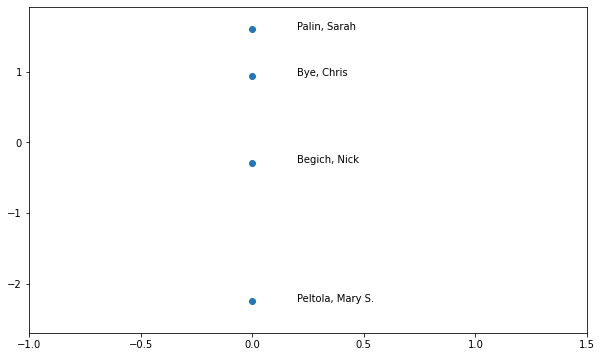

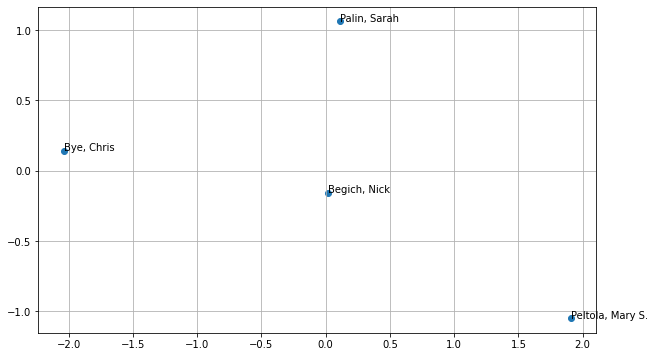

In [23]:
# Test the function with the provided CSV file
rcv_analysis(f"Alaska_11082022_USRepresentative.csv", ignore_values=['skipped', 'overvote', 'writein','Write-in'],metric=True)

C:\Users\Eric Simpson\AppData\Local\Temp\ipykernel_23768\409222877.py:52: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / np.sqrt(freq_upptri)


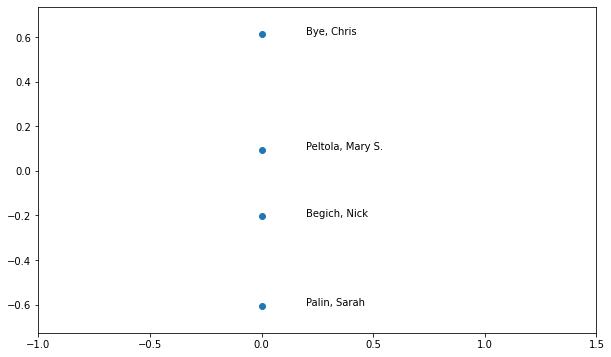

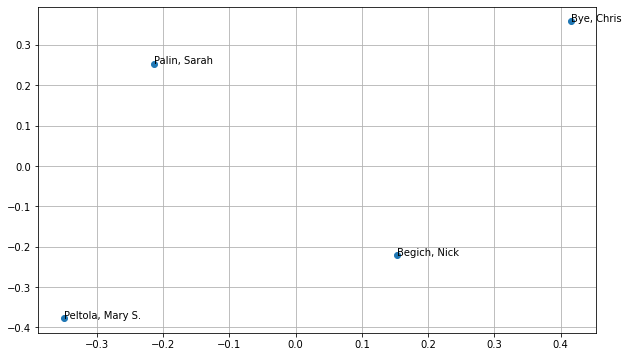

In [22]:
# Test the function with the provided CSV file
rcv_analysis(f"Alaska_11082022_USRepresentative.csv", ignore_values=['skipped', 'overvote', 'writein','Write-in'],metric=False)